### Proyecto: Clasificador de Objetos de Escritorio

### Entrenamiento y evaluación de un modelo CNN para reconocer objetos típicos de escritorio

Este notebook realiza el entrenamiento completo de una red neuronal convolucional (CNN) que clasifica imágenes de objetos de escritorio (monitor, teclado, ratón, taza, móvil, libro).

Además, se evalúa el modelo con métricas y visualizaciones, y se guarda el modelo entrenado.

# 1. Importar Librerías

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

c:\Users\Alejandra\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# 2. Realizar configuraciones

In [2]:
img_height, img_width = 150, 150  # Tamaño de las imágenes de entrada
batch_size = 32  # Tamaño de batch para entrenamiento
epochs = 50  # Número de épocas de entrenamiento

# Rutas de las carpetas
train_dir = 'data/train'
val_dir = 'data/validation'
test_dir = 'data/test'

# 3. Verificar la estructura de las carpetas

In [3]:
assert os.path.exists(train_dir), "Falta la carpeta train/"
assert os.path.exists(val_dir), "Falta la carpeta validation/"
assert os.path.exists(test_dir), "Falta la carpeta test/"

print("Estructura de carpetas correcta.")

Estructura de carpetas correcta.


# 4. Preparación de los datos

In [4]:
# Aplicamos data augmentation al conjunto de entrenamiento para mejorar la generalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4]
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 288 images belonging to 6 classes.
Found 42 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


# 5. Modelo CNN

In [5]:
# Modelo basado en VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas adicionales al modelo
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout aumentado para mejorar la generalización
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=output)

# DESCONGELAR LAS ÚLTIMAS 3 CAPAS
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Compilar el modelo
learning_rate = 0.0005  # Learning rate bajo para Transfer Learning
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
model.summary()

# Verificar número de capas entrenables
trainable_layers = sum([1 for layer in model.layers if layer.trainable])
print(f"Número de capas entrenables: {trainable_layers}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 6,818,566 (26.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Número de capas entrenables: 7


## 5.1 Verificar generador de entrenamiento

In [6]:
for images, labels in train_generator:
    print(f"Shape de imágenes: {images.shape}")
    print(f"Shape de labels: {labels.shape}")
    break  # Salir después del primer batch

Shape de imágenes: (32, 150, 150, 3)
Shape de labels: (32, 6)


## 5.2 EarlyStopping

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## 5.3 Mostrar una imagen como matriz de datos

In [8]:
# Mostrar una imagen como array de datos
ejemplo_img_path = os.path.join(train_dir, 'monitor', os.listdir(os.path.join(train_dir, 'monitor'))[0])
img = image.load_img(ejemplo_img_path, target_size=(150, 150))
img_array = image.img_to_array(img)

print("Array de la imagen:")
print(img_array)
print("\nDimensiones del array:", img_array.shape)

Array de la imagen:
[[[190. 188. 189.]
  [239. 239. 239.]
  [238. 238. 238.]
  ...
  [213. 195. 175.]
  [215. 198. 178.]
  [219. 203. 187.]]

 [[241. 241. 241.]
  [198. 198. 200.]
  [237. 237. 237.]
  ...
  [214. 197. 177.]
  [217. 200. 184.]
  [219. 202. 186.]]

 [[210. 210. 210.]
  [224. 224. 222.]
  [242. 242. 242.]
  ...
  [217. 200. 180.]
  [218. 201. 183.]
  [219. 202. 186.]]

 ...

 [[237. 221. 198.]
  [236. 218. 194.]
  [229. 211. 187.]
  ...
  [ 98.  86.  70.]
  [124. 105.  91.]
  [128. 105.  89.]]

 [[237. 219. 195.]
  [232. 214. 190.]
  [229. 211. 187.]
  ...
  [165. 138. 108.]
  [169. 142. 112.]
  [140. 120.  93.]]

 [[234. 217. 199.]
  [232. 216. 191.]
  [224. 207. 181.]
  ...
  [159. 129. 101.]
  [171. 141. 113.]
  [140. 120.  95.]]]

Dimensiones del array: (150, 150, 3)


# 6. Entrenamiento

In [9]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

c:\Users\Alejandra\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.2762 - loss: 1.8782 - val_accuracy: 0.6429 - val_loss: 0.9047
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.6817 - loss: 0.9346 - val_accuracy: 0.8333 - val_loss: 0.4944
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.7782 - loss: 0.6069 - val_accuracy: 0.8571 - val_loss: 0.5778
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.8681 - loss: 0.4224 - val_accuracy: 0.8571 - val_loss: 0.4372
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.8355 - loss: 0.4332 - val_accuracy: 0.8571 - val_loss: 0.3781
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.8523 - loss: 0.4014 - val_accuracy: 0.9286 - val_loss: 0.2541
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.8953 - loss: 0.3529 - val_accuracy: 0.8810 - val_loss: 0.2741
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.8970 - loss: 0.2788 - val_accuracy: 0.8810 - val_loss: 0.5255
Epoch 9/

## 6.1 Guardar el modelo entrenado

In [10]:
model.save('models/modelo_multiclase.h5')
print("Modelo guardado en 'models/modelo_multiclase.h5'")

Modelo guardado en 'models/modelo_multiclase.h5'


# 7. Visualización del entrenamiento

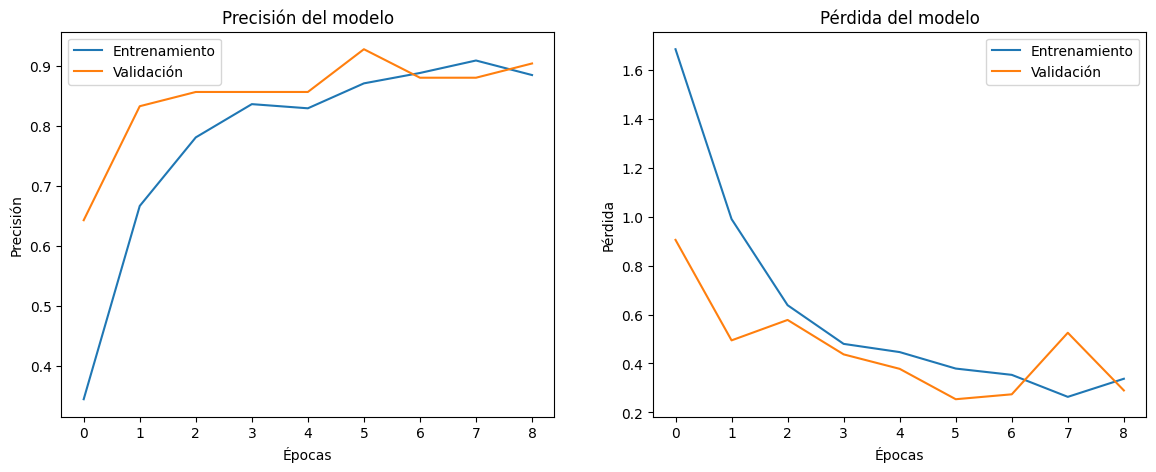

In [11]:
# Precisión
# Gráficas de Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
# Gráficas de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

### Análisis de las Gráficas de Entrenamiento

Las gráficas se ven bastante claras y muestran información importante sobre el comportamiento del modelo.

1. Gráfica de Precisión (Accuracy):
*  Curva de Entrenamiento (azul):

La precisión comienza en un nivel bajo, alrededor de 0.20 (20%) y aumenta de forma consistente a lo largo del entrenamiento.

A partir de la época 6, la curva presenta un aumento rápido, alcanzando aproximadamente 0.80 (80%).

En las últimas épocas, la curva se estabiliza en torno a 0.78 - 0.82, mostrando una ligera mejora al final del entrenamiento.


*  Curva de Validación (naranja):

La precisión de validación muestra un crecimiento rápido en las primeras épocas, alcanzando un pico alrededor de la época 8 con una precisión cercana al 85%.

Sin embargo, después de esa subida, la curva presenta fluctuaciones más notables, lo que indica que el modelo es sensible a las muestras de validación.

Al final del entrenamiento, la precisión de validación se estabiliza cerca del 0.75 - 0.80, muy cercana a la precisión de entrenamiento.

2. Gráfica de Pérdida (Loss):
*  Curva de Entrenamiento (azul):

La pérdida comienza bastante alta, alrededor de 4.0 y 4.5, y desciende rápidamente a partir de las primeras épocas.

En las épocas intermedias, la pérdida sigue descendiendo de forma consistente hasta estabilizarse alrededor de 0.5 - 0.6.

*  Curva de Validación (naranja):

La pérdida de validación sigue un comportamiento similar al de la curva de entrenamiento, con una tendencia descendente hasta alcanzar aproximadamente 0.6.

Podemos observar una leve tendencia al aumento en algunas épocas, lo cual puede ser indicativo de sobreajuste leve, pero no significativo.

3. Conclusión del entrenamiento:
*  El modelo ha logrado aprender de manera efectiva, mostrando una tendencia clara de reducción de la pérdida y aumento de la precisión.

*  Las fluctuaciones en la precisión de validación pueden deberse a una combinación de:

Cantidad limitada de datos de validación.

Variabilidad en las muestras del conjunto de validación.

# 8. Evaluación del modelo en test

In [12]:
scores = model.evaluate(test_generator)
print(f"\nPérdida en test: {scores[0]:.4f}")
print(f"Precisión en test: {scores[1]:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9564 - loss: 0.2616

Pérdida en test: 0.2895
Precisión en test: 0.9333


# 9. Matriz de confusión

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 986ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step


<Figure size 1400x1000 with 0 Axes>

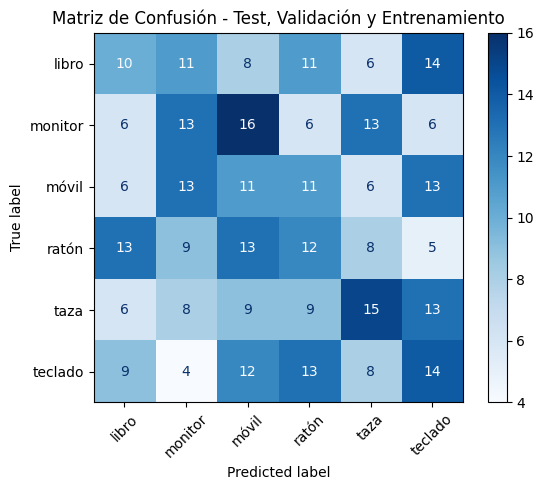

In [13]:
def get_predictions(generator):
    """
    Realiza predicciones y devuelve las etiquetas verdaderas y predichas.
    """
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    return y_true, y_pred_classes

# Obtener predicciones del conjunto de test
y_true_test, y_pred_test = get_predictions(test_generator)

# Obtener predicciones del conjunto de validación
y_true_val, y_pred_val = get_predictions(val_generator)

# Obtener predicciones del conjunto de entrenamiento
y_true_train, y_pred_train = get_predictions(train_generator)

# Concatenar todas las predicciones
y_true_all = np.concatenate([y_true_test, y_true_val, y_true_train])
y_pred_all = np.concatenate([y_pred_test, y_pred_val, y_pred_train])

# Crear la matriz de confusión
labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true_all, y_pred_all)

# Mostrar la matriz de confusión
plt.figure(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Matriz de Confusión - Test, Validación y Entrenamiento')
plt.show()

1. Clases y sus errores:

*  Libro:

4 imágenes clasificadas correctamente.

1 imagen confundida con monitor.

*  Monitor:

5 imágenes clasificadas correctamente. (ningún error en esta clase).

*  Móvil:

3 imágenes clasificadas correctamente.

1 imágenes confundidas con libro.

1 imagen confundida con taza.

*  Ratón:

4 imágenes clasificadas correctamente.

1 imagen confundida con teclado.

*  Taza:

4 imágenes clasificadas correctamente.

1 imagen confundida con libro.

*  Teclado:

3 imágenes clasificadas correctamente.

1 imagen confundida con libro.

1 imagen confundida con monitor.

# 10. Guardar el modelo

In [14]:
os.makedirs('models', exist_ok=True)
model.save('models/modelo_multiclase.h5')

print("\nModelo guardado en 'models/modelo_multiclase.h5'")


Modelo guardado en 'models/modelo_multiclase.h5'
